In [140]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.model_selection import train_test_split

# Check for GPU availability
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
!pip install --upgrade matplotlib

### Reproducibility
Achieving reproducible results is a cornerstone of scientific research. 

In the context of Deep Learning, this means ensuring that a model will produce the same results on the same data, regardless of when or where it is run. This is challenging due to the inherent randomness in model initialization and data shuffling. 
To avoid (or minimize) it, we fix the random seed across all libraries that generate random numbers.

In [4]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

### Hyperparameters

In [5]:
# Hyperparameters
batch_size = 30
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.001

### Dataset

The dataset for this project, obtained from the PizzaGAN project at MIT and accessible on [this website](http://pizzagan.csail.mit.edu/), includes pizza images with labeled toppings. Over 38 million #pizza posts on Instagram were initially filtered to acquire approximately half a million images, with undesired content removed. After this, it was diminished even further until 9,213 pictures with corresponding annotations were left. 

In [99]:
# Import the csv from path.
label_path = "data\pizza_data\imageLabels.txt"
column_path = 'data\pizza_data\categories.txt'
image_path = "data\pizza_data\images"

df = pd.read_csv(label_path, sep = '  ', header = None)
df.columns = open(column_path, 'r').read().split('\n')[:-1]
classes = len(open(column_path, 'r').read().split('\n')[:-1])+1
open(column_path, 'r').close()


# Encode a label of pizzas without labeled toppings.
df["plain"] = 0
df["image_name"] = df.apply(lambda x: os.path.join(image_path, str(x.name).zfill(5)+'.jpg'), axis = 1)
df.loc[df.iloc[:, 1:-1].max(axis=1) == 0, "plain"] = 1

# Split the data in training and validation.
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=7)
train_df

C:\Users\woute\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Pepperoni,Bacon,Mushrooms,Onions,Peppers,Black olives,Tomatoes,Spinach,Fresh basil,Arugula,Broccoli,Corn,Pineapple,plain,image_name
2091,0,1,0,1,0,0,1,0,0,0,0,0,0,0,data\pizza_data\images\02091.jpg
7311,0,0,0,0,0,1,0,0,0,0,0,0,0,0,data\pizza_data\images\07311.jpg
2855,0,0,1,0,0,0,1,0,1,0,0,0,0,0,data\pizza_data\images\02855.jpg
8371,0,0,0,0,0,0,0,0,1,0,0,0,0,0,data\pizza_data\images\08371.jpg
4000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data\pizza_data\images\04000.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0,1,0,0,0,0,0,0,1,0,0,0,0,0,data\pizza_data\images\01372.jpg
919,0,0,0,1,0,0,0,0,0,0,0,0,0,0,data\pizza_data\images\00919.jpg
4307,0,0,0,0,0,0,1,0,0,0,0,0,0,0,data\pizza_data\images\04307.jpg
5699,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data\pizza_data\images\05699.jpg


In [54]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iat[idx, -1]  # the path is in the first column
        image = Image.open(image_name).convert("RGB")
        labels = torch.tensor(
            self.dataframe.drop('image_name', axis = 1).iloc[idx].values.astype("float32")
        )  # Convert to tensor

        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, labels

In [87]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 5000 - Test set size: 1843


Let's normalize the input data, to improve the learning process, by using Standard Normalization.
we first need to calculate the mean and variance of the pixel values across the entire training dataset. These statistics are then used to normalize both the training and validation/test datasets. 

In [92]:
full_train_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2588, 0.2706],
         [0.0000, 0.0000, 0.0000,  ..., 0.2706, 0.2784, 0.2941],
         [0.0000, 0.0000, 0.0000,  ..., 0.2745, 0.2706, 0.2863],
         ...,
         [0.0549, 0.0784, 0.1020,  ..., 0.0000, 0.0000, 0.0000],
         [0.0549, 0.0784, 0.1020,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0824, 0.1098,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.1882, 0.2000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.2078, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.2000, 0.2157],
         ...,
         [0.0314, 0.0471, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0353, 0.0510, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0549, 0.0784,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1098, 0.1098, 0.1098,  ..., 0.2588, 0.2431, 0.2549],
         [0.1098, 0.1098, 0.1098,  ..., 0.2627, 0.2627, 0.2784],
         [0.1098, 0.1098, 0.1098,  ..., 0.2627, 0.2549, 0.

In [45]:
test_df.loc[4315]

Pepperoni                                      1
Bacon                                          0
Mushrooms                                      0
Onions                                         1
Peppers                                        0
Black olives                                   0
Tomatoes                                       0
Spinach                                        0
Fresh basil                                    0
Arugula                                        0
Broccoli                                       0
Corn                                           0
Pineapple                                      1
plain                                          0
image_name      data\pizza_data\images\04315.jpg
Name: 4315, dtype: object

In [72]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0
    
    for iteration in tqdm(iter(loader)):
        images = iteration[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0)
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance


# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 246/246 [03:51<00:00,  1.06it/s]

Mean: tensor([0.6248, 0.4793, 0.3625])
Standard Deviation: tensor([0.2326, 0.2436, 0.2432])


Furthermore, we need to add the input normalization.

In [75]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 5000 - Test set size: 1843


## Input visualization

Let's visualize a set of images from the dataset.

Labels: Spinach
tensor([[[0.1608, 0.1686, 0.2196,  ..., 0.7216, 0.7176, 0.7176],
         [0.1608, 0.2118, 0.2235,  ..., 0.7255, 0.7216, 0.7216],
         [0.1686, 0.1882, 0.1804,  ..., 0.7255, 0.7255, 0.7255],
         ...,
         [0.7216, 0.7216, 0.7294,  ..., 0.8353, 0.8353, 0.8353],
         [0.7216, 0.7294, 0.7255,  ..., 0.8353, 0.8392, 0.8353],
         [0.7294, 0.7333, 0.7294,  ..., 0.8353, 0.8353, 0.8314]],

        [[0.1333, 0.1373, 0.1882,  ..., 0.7490, 0.7451, 0.7451],
         [0.1412, 0.1882, 0.2000,  ..., 0.7529, 0.7490, 0.7490],
         [0.1490, 0.1725, 0.1686,  ..., 0.7529, 0.7529, 0.7529],
         ...,
         [0.7255, 0.7255, 0.7333,  ..., 0.8392, 0.8392, 0.8392],
         [0.7216, 0.7333, 0.7294,  ..., 0.8392, 0.8431, 0.8392],
         [0.7294, 0.7373, 0.7333,  ..., 0.8392, 0.8392, 0.8353]],

        [[0.1059, 0.1255, 0.1882,  ..., 0.7725, 0.7765, 0.7765],
         [0.1373, 0.1843, 0.1961,  ..., 0.7765, 0.7804, 0.7804],
         [0.1804, 0.1843, 0.1569,  ..., 0.

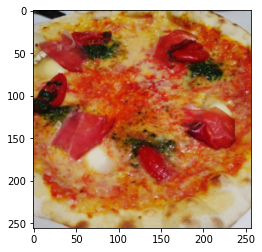

Labels: Spinach
Labels: Arugula
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


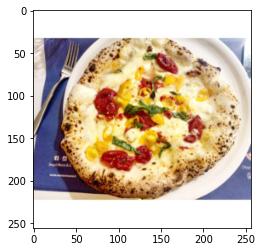

Labels: Tomatoes
tensor([[[0.8588, 0.8314, 0.8000,  ..., 0.7412, 0.8000, 0.7843],
         [0.8549, 0.8902, 0.8118,  ..., 0.6275, 0.6706, 0.7020],
         [0.8549, 0.9255, 0.8549,  ..., 0.5137, 0.5216, 0.5647],
         ...,
         [0.7608, 0.7843, 0.7922,  ..., 0.6078, 0.4471, 0.4667],
         [0.6745, 0.7020, 0.7333,  ..., 0.6627, 0.5333, 0.5020],
         [0.6353, 0.6745, 0.6745,  ..., 0.6745, 0.5765, 0.5294]],

        [[0.6157, 0.5922, 0.5333,  ..., 0.6588, 0.7333, 0.7216],
         [0.6471, 0.7059, 0.6196,  ..., 0.5216, 0.5686, 0.6000],
         [0.6588, 0.7922, 0.7451,  ..., 0.3843, 0.3765, 0.4196],
         ...,
         [0.4745, 0.5020, 0.5137,  ..., 0.3451, 0.2353, 0.2706],
         [0.3647, 0.4039, 0.4549,  ..., 0.3843, 0.3020, 0.2824],
         [0.3059, 0.3608, 0.3804,  ..., 0.4118, 0.3333, 0.2941]],

        [[0.3529, 0.3294, 0.2627,  ..., 0.6392, 0.7020, 0.6863],
         [0.4275, 0.5176, 0.4039,  ..., 0.5294, 0.5529, 0.5804],
         [0.4431, 0.6667, 0.6078,  ..., 0

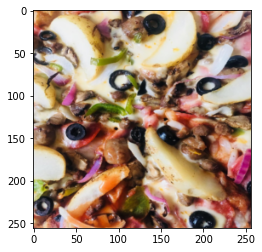

Labels: Peppers
Labels: Black olives
tensor([[[0.8784, 0.8863, 0.8863,  ..., 0.8392, 0.8431, 0.8431],
         [0.8863, 0.8902, 0.8863,  ..., 0.8392, 0.8431, 0.8431],
         [0.8863, 0.8863, 0.8902,  ..., 0.8471, 0.8431, 0.8431],
         ...,
         [0.5765, 0.5882, 0.5294,  ..., 0.8549, 0.8471, 0.8471],
         [0.6549, 0.6392, 0.6196,  ..., 0.8588, 0.8549, 0.8549],
         [0.6510, 0.6471, 0.6235,  ..., 0.8627, 0.8627, 0.8706]],

        [[0.9059, 0.9137, 0.9137,  ..., 0.8471, 0.8431, 0.8431],
         [0.9137, 0.9176, 0.9137,  ..., 0.8471, 0.8431, 0.8431],
         [0.9137, 0.9137, 0.9176,  ..., 0.8549, 0.8471, 0.8431],
         ...,
         [0.4431, 0.4471, 0.3922,  ..., 0.8667, 0.8667, 0.8706],
         [0.5098, 0.4902, 0.4745,  ..., 0.8706, 0.8627, 0.8627],
         [0.5020, 0.4980, 0.4745,  ..., 0.8706, 0.8667, 0.8745]],

        [[0.9294, 0.9373, 0.9373,  ..., 0.8039, 0.8039, 0.8039],
         [0.9373, 0.9412, 0.9373,  ..., 0.8039, 0.8039, 0.8039],
         [0.9373, 0.9

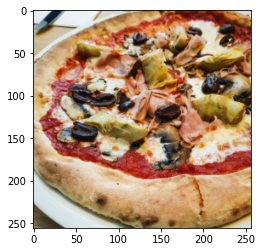

Labels: image_name
tensor([[[0.3216, 0.3333, 0.3412,  ..., 0.6275, 0.6314, 0.6314],
         [0.3294, 0.3412, 0.3490,  ..., 0.6235, 0.6314, 0.6275],
         [0.3333, 0.3451, 0.3569,  ..., 0.6157, 0.6235, 0.6235],
         ...,
         [0.4118, 0.4196, 0.4314,  ..., 0.6863, 0.6745, 0.6667],
         [0.4118, 0.4196, 0.4235,  ..., 0.6980, 0.6824, 0.6706],
         [0.4078, 0.4157, 0.4157,  ..., 0.7020, 0.6902, 0.6784]],

        [[0.2588, 0.2667, 0.2667,  ..., 0.5216, 0.5255, 0.5255],
         [0.2667, 0.2745, 0.2745,  ..., 0.5137, 0.5255, 0.5294],
         [0.2745, 0.2784, 0.2863,  ..., 0.5020, 0.5255, 0.5294],
         ...,
         [0.2980, 0.3059, 0.3176,  ..., 0.6000, 0.5882, 0.5804],
         [0.2980, 0.3059, 0.3098,  ..., 0.6118, 0.5961, 0.5843],
         [0.2941, 0.3020, 0.3020,  ..., 0.6157, 0.6039, 0.5922]],

        [[0.2157, 0.2157, 0.2118,  ..., 0.3294, 0.3176, 0.3137],
         [0.2196, 0.2196, 0.2157,  ..., 0.3294, 0.3216, 0.3176],
         [0.2196, 0.2196, 0.2157,  ...,

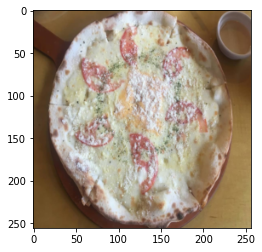

In [84]:
def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = (
        torch.tensor(mean).reshape(-1, 1, 1)
        if not isinstance(mean, torch.Tensor)
        else mean.reshape(-1, 1, 1)
    )
    std = (
        torch.tensor(std).reshape(-1, 1, 1)
        if not isinstance(std, torch.Tensor)
        else std.reshape(-1, 1, 1)
    )
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img


def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return npimg


def display_labels(labels, classes):
    """Display labels given their indices and corresponding class names"""
    for idx, label in enumerate(labels):
        if label == 1:
            print(f"Labels: {classes[idx]}")


# Select random images and plot them with labels
classes = df.columns[1:]

# Select random images and plot them with labels
num_images = 5
for i in random.sample(range(len(test_dataset)), num_images):
    image, labels = (
        test_dataset[i][0],
        test_dataset[i][1],
    )  # Ensure that you're accessing the tensor image

    # Display the labels
    display_labels(labels, classes)

    # Display the image
    imshow(image, mean, std)

tensor([[[0.7890, 0.7763, 0.7516,  ..., 0.7598, 0.7753, 0.7945],
         [0.7991, 0.7945, 0.7881,  ..., 0.7589, 0.7744, 0.7981],
         [0.8064, 0.7991, 0.7863,  ..., 0.7498, 0.7717, 0.7918],
         ...,
         [0.8009, 0.8018, 0.8027,  ..., 0.6604, 0.6650, 0.6704],
         [0.8018, 0.8054, 0.8036,  ..., 0.6613, 0.6631, 0.6677],
         [0.8073, 0.8054, 0.8009,  ..., 0.6686, 0.6668, 0.6613]],

        [[0.6751, 0.6608, 0.6330,  ..., 0.5815, 0.6197, 0.6560],
         [0.6837, 0.6808, 0.6713,  ..., 0.5891, 0.6311, 0.6722],
         [0.6856, 0.6827, 0.6646,  ..., 0.5948, 0.6321, 0.6684],
         ...,
         [0.6818, 0.6827, 0.6837,  ..., 0.5222, 0.5280, 0.5337],
         [0.6837, 0.6865, 0.6856,  ..., 0.5251, 0.5280, 0.5337],
         [0.6894, 0.6875, 0.6827,  ..., 0.5347, 0.5375, 0.5318]],

        [[0.5618, 0.5475, 0.5265,  ..., 0.4445, 0.4855, 0.5370],
         [0.5714, 0.5647, 0.5523,  ..., 0.4512, 0.4951, 0.5523],
         [0.5694, 0.5580, 0.5246,  ..., 0.4531, 0.4941, 0.

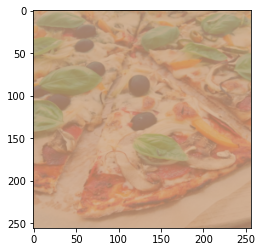

(3, 256, 256)

In [95]:
imshow(test_dataset[0][0], mean, std).shape

## Basic Neural Network Architecture

Let's start our exploration with a basic Linear Model to establish a performance baseline.
 
This model, consisting of a single linear layer, is quick to train but typically underperforms on complex tasks due to its inability to capture non-linear relations in the training data.

In [146]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.Dropout(p = 0.5, inplace = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 16, kernel_size= 5, stride = 3, padding = 2),
            torch.nn.Dropout(p = 0.2, inplace = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(16, 1, kernel_size = 7, stride = 3, padding = 2),
            torch.nn.Dropout(p=0.3, inplace = True),
            nn.LeakyReLU(negative_slope=0.2, inplace = True),
            nn.Flatten(),
            nn.Linear(784, 64), 
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(classes).to(device)
summary(linear_model, (3,256,256), device = device)
print('Device is ' + device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
           Dropout-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4           [-1, 16, 86, 86]          25,616
           Dropout-5           [-1, 16, 86, 86]               0
              ReLU-6           [-1, 16, 86, 86]               0
            Conv2d-7            [-1, 1, 28, 28]             785
           Dropout-8            [-1, 1, 28, 28]               0
         LeakyReLU-9            [-1, 1, 28, 28]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                   [-1, 64]          50,240
        LeakyReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 14]             910
          Sigmoid-14                   

Show more model information regarding parameters.

In [143]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in linear_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: linear_stack.0.weight, Parameters: 1728
Layer: linear_stack.0.bias, Parameters: 64
Layer: linear_stack.3.weight, Parameters: 25600
Layer: linear_stack.3.bias, Parameters: 16
Layer: linear_stack.6.weight, Parameters: 784
Layer: linear_stack.6.bias, Parameters: 1
Layer: linear_stack.10.weight, Parameters: 50176
Layer: linear_stack.10.bias, Parameters: 64
Layer: linear_stack.12.weight, Parameters: 896
Layer: linear_stack.12.bias, Parameters: 14

Total number of parameters: 79343


## Loss function and optimizer

When choosing a loss function and an optimizer for a neural network, it's important to consider the specific task at hand. 

For classification tasks, Cross Entropy Loss and optimizers like SGD or Adam are common choices. 

In [144]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.1)

## Model Training

The training loop is where the model learns from the data. In each epoch, the model makes predictions, calculates the error (loss), and uses backpropagation to adjust the weights. 

### Training Process Overview

During training, for each batch of data, the following steps occur:
1. **Forward Pass:** The model computes predictions based on the input data.
2. **Compute Loss:** The difference between the predictions and the actual labels is calculated using the loss function.
3. **Backward Pass:** The model backpropagates the loss to compute the gradients of the loss with respect to each parameter.
4. **Update Parameters:** The optimizer uses the gradients calculated during the backward pass to update the model's parameters.

In [145]:
# Training and Validation Loop
for epoch in tqdm(range(epochs)):
    print('starting epoch...')
    # Training Phase
    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images, labels = images.to(device), torch.max(labels, 1)[1].to(
            device
        )  # Move data to the appropriate device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

  0%|          | 0/50 [00:00<?, ?it/s]

starting epoch...


  0%|          | 0/50 [01:16<?, ?it/s]


KeyboardInterrupt: 

In [159]:
criterion(torch.Tensor([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 0.5,0.5,0.5,0.5,0.5,0.5]).reshape((1,18)), torch.Tensor([1,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0]).reshape((1,18)))

tensor(31.7941)

In [150]:
torch.Tensor([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 0.5,0.5,0.5,0.5,0.5,0.5])

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])

In [151]:
torch.Tensor([1,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0])

tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.])